### Load KITTI Dataset in Python

In [2]:
import pykitti


basedir = "/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset/"


sequence = "00"


dataset = pykitti.odometry(basedir, sequence)


print(f"Loaded {len(dataset.timestamps)} frames from sequence {sequence}")


Loaded 4541 frames from sequence 00


### Visualize LiDAR Data

In [3]:
import open3d as o3d
import numpy as np

# Load the first LiDAR frame (frame 0)
scan = dataset.get_velo(0)

# Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(scan[:, :3])  # Use x, y, z coordinates

# Visualize the LiDAR point cloud
o3d.visualization.draw_geometries([pcd])

# import open3d as o3d
# import numpy as np
# import time

# # Load all LiDAR frames from KITTI sequence 00
# num_frames = len(dataset.timestamps)  # Total frames
# vis = o3d.visualization.Visualizer()
# vis.create_window()

# pcd = o3d.geometry.PointCloud()

# for i in range(num_frames):  # Loop through all frames
#     scan = dataset.get_velo(i)  # Load LiDAR frame
#     pcd.points = o3d.utility.Vector3dVector(scan[:, :3])  # Convert to Open3D format

#     if i == 0:
#         vis.add_geometry(pcd)
#     else:
#         vis.update_geometry(pcd)

#     vis.poll_events()
#     vis.update_renderer()
#     time.sleep(0.05)  # Adjust speed of animation

# vis.destroy_window()



### Implement Basic ICP SLAM

# ICP-based SLAM Explanation

## What This Code Does

- Loads **two LiDAR scans** (`pcd1` and `pcd2`).
- Uses **Iterative Closest Point (ICP)** to align `pcd2` to `pcd1`.
- Computes a **transformation matrix** that represents how `pcd2` should be moved to match `pcd1`.

## Transformation Matrix

The transformation matrix output looks like this:

\[
\begin{bmatrix} 
R_{11} & R_{12} & R_{13} & t_x \\ 
R_{21} & R_{22} & R_{23} & t_y \\ 
R_{31} & R_{32} & R_{33} & t_z \\ 
0 & 0 & 0 & 1 
\end{bmatrix}
\]

Where:
- **R** represents **rotation** (how the scan is rotated).
- **t** represents **translation** (how the scan is shifted).

## Why This is Useful

This matrix updates the robot’s **position** and **map**, helping it track movement over time. 🚀


Processing Frames: 100%|██████████| 4540/4540 [06:42<00:00, 11.28it/s]


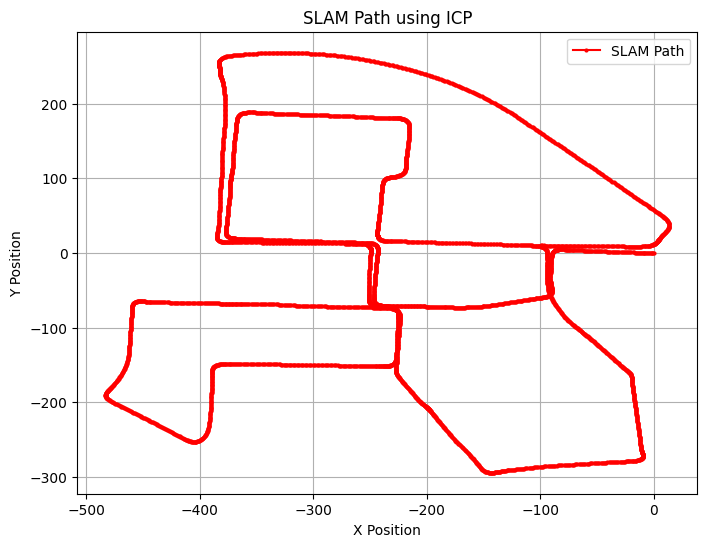

In [4]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  




def icp_slam(source, target, threshold=0.5):
    """Applies Iterative Closest Point (ICP) for SLAM with preprocessing"""
    
    
    source = source.voxel_down_sample(voxel_size=0.3)
    target = target.voxel_down_sample(voxel_size=0.3)

    
    target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

    
    icp = o3d.pipelines.registration.registration_icp(
        source, target, threshold, np.eye(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=50)
    )
    
    
    translation = np.linalg.norm(icp.transformation[:3, 3])
    if translation > 1.5:  
        print("Warning: Large transformation detected, skipping frame")
        return np.eye(4)
    
    return icp.transformation



trajectory = [np.eye(4)]  


pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(dataset.get_velo(0)[:, :3])

num_frames = 4541  


for i in tqdm(range(1, num_frames), desc="Processing Frames"):
    pcd2 = o3d.geometry.PointCloud()
    pcd2.points = o3d.utility.Vector3dVector(dataset.get_velo(i)[:, :3])

    transformation = icp_slam(pcd1, pcd2)

    trajectory.append(trajectory[-1] @ transformation)
    
    pcd1 = pcd2  


trajectory = np.array(trajectory)[:, :3, 3]  


plt.figure(figsize=(8, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'ro-', markersize=2, label="SLAM Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("SLAM Path using ICP")
plt.legend()
plt.grid()
plt.show()


### Ground Truth Path

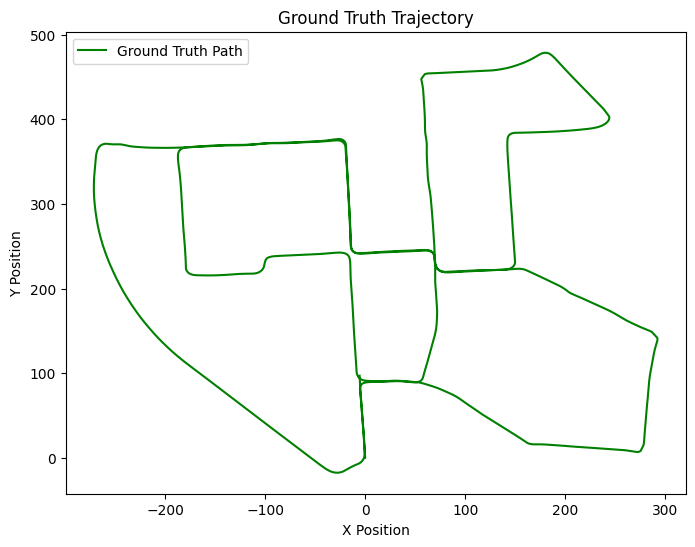

In [5]:
import numpy as np
import matplotlib.pyplot as plt


gt_poses = np.loadtxt("/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset/poses/00.txt")
gt_poses = gt_poses.reshape(-1, 3, 4)


gt_x = gt_poses[:, 0, 3]  
gt_y = gt_poses[:, 2, 3]  
gt_trajectory = np.vstack((gt_x, gt_y)).T  


plt.figure(figsize=(8, 6))
plt.plot(gt_trajectory[:, 0], gt_trajectory[:, 1], 'g-', label='Ground Truth Path')

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Ground Truth Trajectory")
plt.show()


### Slam vs Ground Path

/tmp/ipykernel_1102690/3840640138.py:46: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', marker='o', linestyle='-', label='SLAM Path')


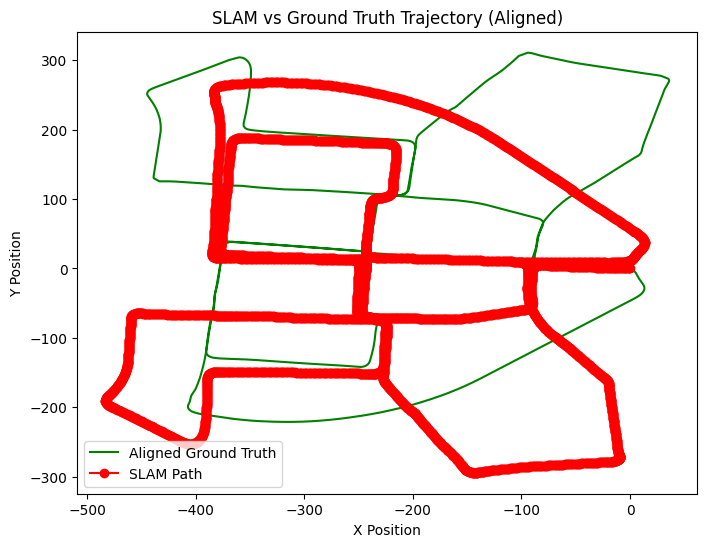

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def rotate_trajectory(points, angle):
    """
    Rotates the given trajectory by a specified angle.

    Parameters:
        points (numpy.ndarray): (N, 2) array of (x, y) coordinates.
        angle (float): Rotation angle in radians.

    Returns:
        numpy.ndarray: Rotated trajectory.
    """
    R = np.array([[np.cos(angle), -np.sin(angle)], 
                  [np.sin(angle), np.cos(angle)]])
    return points @ R.T  


gt_poses = np.loadtxt("/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset/poses/00.txt")
gt_poses = gt_poses.reshape(-1, 3, 4)


gt_x = gt_poses[:, 0, 3]  
gt_y = gt_poses[:, 2, 3]  
gt_trajectory = np.vstack((gt_x, gt_y)).T  


trajectory = np.array(trajectory)  
trajectory = trajectory[:, :2]  


angle = np.arctan2(trajectory[-1, 1] - trajectory[0, 1], trajectory[-1, 0] - trajectory[0, 0]) - \
        np.arctan2(gt_trajectory[-1, 1] - gt_trajectory[0, 1], gt_trajectory[-1, 0] - gt_trajectory[0, 0])


rotated_gt_trajectory = rotate_trajectory(gt_trajectory, angle)


translation = trajectory[0] - rotated_gt_trajectory[0]  
rotated_gt_trajectory += translation  


plt.figure(figsize=(8, 6))
plt.plot(rotated_gt_trajectory[:, 0], rotated_gt_trajectory[:, 1], 'g-', label='Aligned Ground Truth')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', marker='o', linestyle='-', label='SLAM Path')

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("SLAM vs Ground Truth Trajectory (Aligned)")
plt.show()


## Step 1: Load Point Cloud

In [7]:
def load_point_cloud(filename):
    # Each point is stored as (x, y, z, reflectance) in float32
    return np.fromfile(filename, dtype=np.float32).reshape(-1, 4)


## Step 2: Filter and Project to 2D

In [8]:
def get_2d_projection(points):
    # Select only ground-level points by z range (optional)
    filtered = points[(points[:, 2] > -2) & (points[:, 2] < 2)]  # z in [-2m, 2m]
    return filtered[:, :2]  # Only x, y


## Step 3: Generate Occupancy Grid

In [9]:
def create_occupancy_grid(points_2d, grid_size=0.2, grid_width=100, grid_height=100):
    """
    Converts 2D point cloud into an occupancy grid.
    - grid_size: size of each cell in meters.
    - grid_width, grid_height: total grid dimensions in meters.
    """
    # Create an empty grid: -1 = unknown, 0 = free, 1 = occupied
    grid = -np.ones((int(grid_height/grid_size), int(grid_width/grid_size)), dtype=np.int8)

    # Shift coordinates to be positive
    x = points_2d[:, 0] + (grid_width / 2)
    y = points_2d[:, 1] + (grid_height / 2)

    # Convert to grid indices
    xi = (x / grid_size).astype(np.int32)
    yi = (y / grid_size).astype(np.int32)

    # Filter out-of-bound indices
    valid = (xi >= 0) & (xi < grid.shape[1]) & (yi >= 0) & (yi < grid.shape[0])
    xi = xi[valid]
    yi = yi[valid]

    # Mark cells as occupied
    grid[yi, xi] = 1

    return grid


## Step 4: Visualize the Occupancy Grid

In [10]:
def plot_occupancy_grid(grid):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray', origin='lower')
    plt.title("2D Occupancy Grid Map")
    plt.xlabel("X (grid cells)")
    plt.ylabel("Y (grid cells)")
    plt.colorbar(label="Occupancy")
    plt.show()


100%|██████████| 300/300 [00:02<00:00, 136.23it/s]


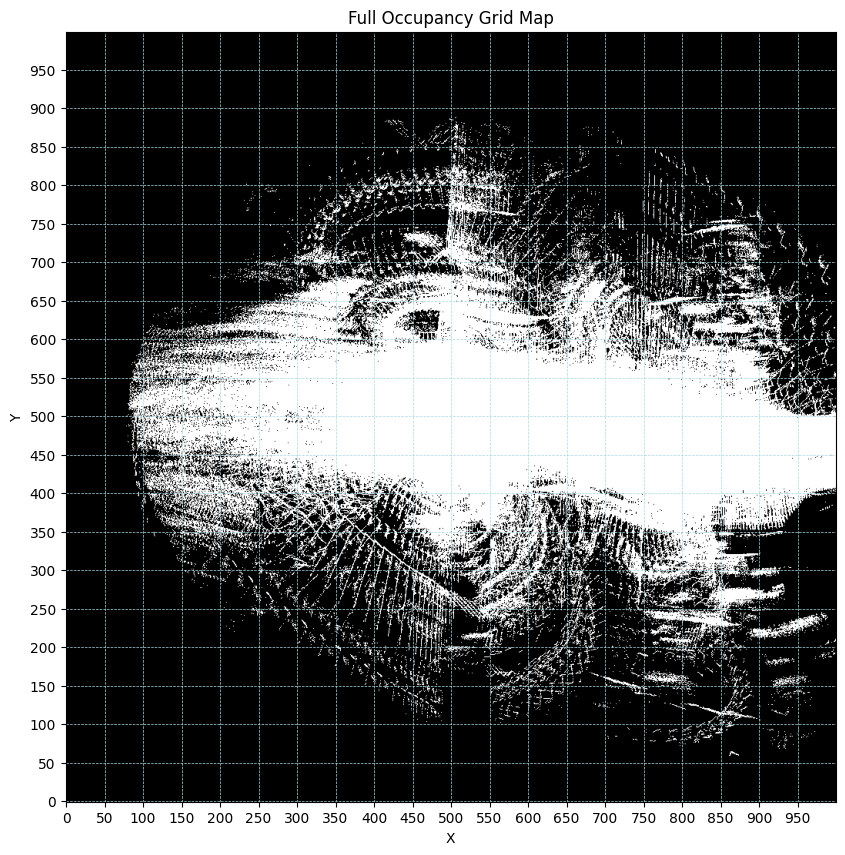

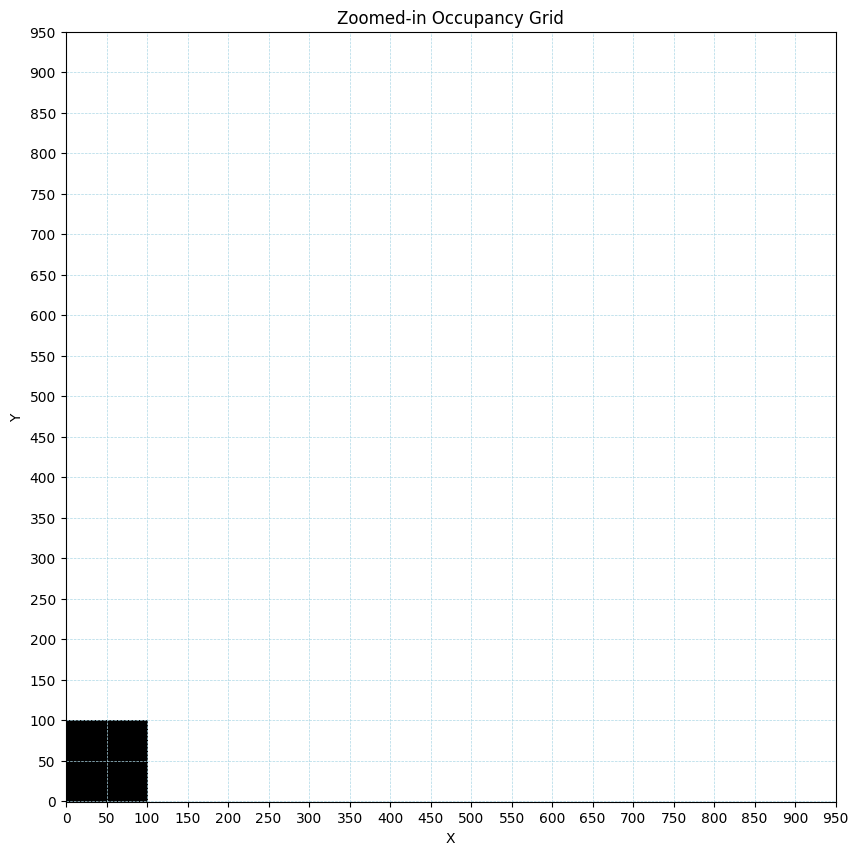

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def load_point_cloud(bin_path):
    """Load a Velodyne .bin file into Nx4 numpy array (x, y, z, reflectance)."""
    return np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

def get_2d_projection(points, height_threshold=(-2, 1.5)):
    """Project 3D points to 2D top-down (x, y) and filter based on z (height)."""
    mask = (points[:, 2] > height_threshold[0]) & (points[:, 2] < height_threshold[1])
    return points[mask][:, :2]

def load_poses(pose_file):
    """Load 3x4 pose matrices from KITTI pose file."""
    poses = np.loadtxt(pose_file).reshape(-1, 3, 4)
    matrices = []
    for pose in poses:
        matrix = np.eye(4)
        matrix[:3, :4] = pose
        matrices.append(matrix)
    return matrices

def transform_points(points, transform):
    """Apply 4x4 transformation matrix to Nx2 points."""
    N = points.shape[0]
    hom = np.hstack((points, np.zeros((N, 1)), np.ones((N, 1))))  # (x, y, z=0, 1)
    transformed = (transform @ hom.T).T
    return transformed[:, :2]  # return only x, y

def create_occupancy_grid(all_points, grid_size=0.2, grid_extent=100):
    """Create a colorized occupancy grid: 0=unknown, 128=free, 255=occupied."""
    grid_dim = int(2 * grid_extent / grid_size)
    grid = np.full((grid_dim, grid_dim), 128, dtype=np.uint8)  # default to "free" (gray)

    for pt in all_points:
        x, y = pt
        i = int((x + grid_extent) / grid_size)
        j = int((y + grid_extent) / grid_size)

        if 0 <= i < grid_dim and 0 <= j < grid_dim:
            grid[j, i] = 255  # Occupied
    return grid

def plot_occupancy_grid(grid, grid_size=0.2, grid_extent=100, zoom=False):
    """Plot full or zoomed occupancy grid with grid lines."""
    fig, ax = plt.subplots(figsize=(10, 10))

    if zoom:
        center = grid.shape[0] // 2
        zoom_size = 100  # show 100x100 area
        half = zoom_size // 2
        zoomed_grid = grid[center-half:center+half, center-half:center+half]
        ax.imshow(zoomed_grid, cmap='gray', origin='lower')
        ax.set_title("Zoomed-in Occupancy Grid")
    else:
        ax.imshow(grid, cmap='gray', origin='lower')
        ax.set_title("Full Occupancy Grid Map")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # Add grid lines for navigation
    ticks = np.arange(0, grid.shape[0], int(10 / grid_size))  # grid every 10 meters
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.grid(True, color='lightblue', linestyle='--', linewidth=0.5)

    plt.show()

if __name__ == "__main__":
    # === Paths ===
    sequence = "00"
    base_dir = "/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset"
    velo_dir = os.path.join(base_dir, f"sequences/{sequence}/velodyne")
    pose_file = os.path.join(base_dir, f"poses/{sequence}.txt")

    # === Load Poses (first 300 only) ===
    poses = load_poses(pose_file)[:300]

    # === Initialize global point set ===
    all_points_world = []

    # === Process first 300 point cloud frames ===
    files = sorted(os.listdir(velo_dir))[:300]
    for i, filename in tqdm(enumerate(files), total=len(files)):
        bin_path = os.path.join(velo_dir, filename)

        # 1. Load point cloud and project to 2D
        point_cloud = load_point_cloud(bin_path)
        points_2d = get_2d_projection(point_cloud)

        # 2. Transform to global frame
        world_points = transform_points(points_2d, poses[i])
        all_points_world.append(world_points)

    # === Combine all transformed points ===
    all_points_world = np.vstack(all_points_world)

    # === Create and plot full occupancy grid ===
    occupancy_grid = create_occupancy_grid(all_points_world, grid_size=0.2, grid_extent=100)
    plot_occupancy_grid(occupancy_grid)

    # === Plot zoomed-in grid (center region) ===
    plot_occupancy_grid(occupancy_grid, zoom=True)


### Implement A Path Planning*

In [12]:
# import heapq

# def astar(grid, start, goal):
#     """A* Algorithm for Path Planning"""
#     rows, cols = len(grid), len(grid[0])
#     heap = [(0, start)]
#     came_from = {start: None}
#     cost_so_far = {start: 0}

#     while heap:
#         _, current = heapq.heappop(heap)
#         if current == goal:
#             break
#         for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
#             next_node = (current[0] + dx, current[1] + dy)
#             if 0 <= next_node[0] < rows and 0 <= next_node[1] < cols:
#                 new_cost = cost_so_far[current] + 1
#                 if next_node not in cost_so_far or new_cost < cost_so_far[next_node]:
#                     cost_so_far[next_node] = new_cost
#                     priority = new_cost
#                     heapq.heappush(heap, (priority, next_node))
#                     came_from[next_node] = current
#     return came_from

# # Example grid-based path planning
# grid = [[0]*10 for _ in range(10)]  # 10x10 empty grid
# start, goal = (0, 0), (9, 9)
# path = astar(grid, start, goal)
# print("Path found:", path)

### Visualize and Evaluate Results


In [13]:
# import matplotlib.pyplot as plt

# trajectory = np.array([[0, 0], [1, 2], [2, 3]])  # Example trajectory
# plt.plot(trajectory[:, 0], trajectory[:, 1], marker="o", label="SLAM Path")
# plt.legend()
# plt.show()